In [1]:
%matplotlib inline
#os module to handle paths and directories 
import os
#cv2 library is for OpenCV image manipulation functions 
import cv2
#seaborn is for data visualization
import seaborn 
#numpy for numerical processing 
import numpy as np
#pandas for dataframe manipulation functions 
import pandas as pd 
#for random number generation
import random
#for notebook related function 
import tqdm
from tqdm import notebook
#to create data augmentation pipeline and pytorch 
import albumentations as A
from albumentations import pytorch
#for plotting and data visualization 
import matplotlib.pyplot as plt
#torch for neural network creation and training 
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torchvision

In [2]:
#the images are downloaded and stored into cityscapes_data from where they will be read 
images_dir = r'./cityscapes_data'
train_images_dir = os.path.join(images_dir, 'train')
val_images_dir = os.path.join(images_dir, 'val')
working_dir = '/kaggle/working'

#created paths to store the model weights and logging error and training information 
weights_path = os.path.join(working_dir, 'unet4_weights.pth')
logs_path = os.path.join(working_dir, 'logs')

In [3]:
#the generic class of data generator to create and dispatch batches of training data into the model for training
class Generator(object):
    def __init__(self, images_dir, batch_size, is_augmentation, shuffle = True, rescale = 1.00, target_size = (128, 128)):
        super(Generator, self).__init__()
        #path from where images are to be taken 
        self.images_dir = images_dir
        #the number of images in particular batch of training data that is presented to the model while training proceeds
        self.batch_size = batch_size
        #rescale factor which is set to 1, ie. no scaling 
        self.rescale = rescale
        #shuffling the data for training, improves performance of the model being trained
        self.shuffle = shuffle
        #whether to apply augmentation or not 
        self.is_augmentation = is_augmentation
        #size of the image that shd be output by this generator 
        self.target_size = target_size
        #processing for creating batches of training data 
        self.filenames = [os.path.join(self.images_dir, filename) for filename in os.listdir(self.images_dir)]
        self.current_step = 0
        self.count_images = len(self.filenames)
        self.available_steps = int(self.count_images // self.batch_size)
        #image manipulation for data augmentation 
        #this pipeline is composed of rotation by 25 degree counter clockwise, followed of RGBShift/HueSaturation and then by CLAHE/RandomGamma
        self.transforms = A.Compose([
            A.Rotate(25), 
            A.OneOf([
                A.RGBShift(), A.HueSaturationValue()
            ]),
            A.OneOf([
                A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()
            ]), 
        ])
        
    #function for converting data into numerical form and creating a batch of input,output image pairs and returning as numpy array   
    def augmentate(self, batch):
        batch = batch.astype(np.uint8)
        batch = [self.transforms(image = image, mask = mask) for (image, mask) in batch]
        batch = np.array([(transformed['image'], transformed['mask']) for transformed in batch], dtype = np.float32)
        return batch

    #this function generates batches the details are mentioned within 
    def generate_batch(self):
        start = self.current_step * self.batch_size
        stop = (self.current_step + 1) * self.batch_size
        filenames_batch = self.filenames[start:stop]
        
        #batch of original images from directory
        images_batch = [cv2.imread(filename) for filename in filenames_batch]
        
        #change channeld order to rgb
        images_batch = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images_batch])
        
        #split original images by image and mask
        images_batch = np.array([(image[:, :256,], image[:, 256:]) for image in images_batch]) 
        
        #resize images 
        images_batch = np.array([(cv2.resize(image, self.target_size), cv2.resize(mask, self.target_size)) for (image, mask) in images_batch], dtype = np.float32)
        #augmentation
        if self.is_augmentation:
            images_batch = self.augmentate(images_batch)
        
        #set 'channel_first' order
        images_batch = np.array([(np.moveaxis(image, -1, 0), np.moveaxis(mask, -1, 0)) for (image, mask) in images_batch])
        
        #rescaling 
        images_batch /= self.rescale
        #resampling 
        images_batch = np.moveaxis(images_batch, 1, 0)
        
        return torch.Tensor(images_batch)
    
    #functions to perform some housekeeping and generating batched at the time of training 
    def __next__(self):
        if self.current_step > self.available_steps:
            self.current_step = 0
        images, masks = self.generate_batch()
        self.current_step += 1
        return images, masks

    def __len__(self):
        return self.available_steps
        

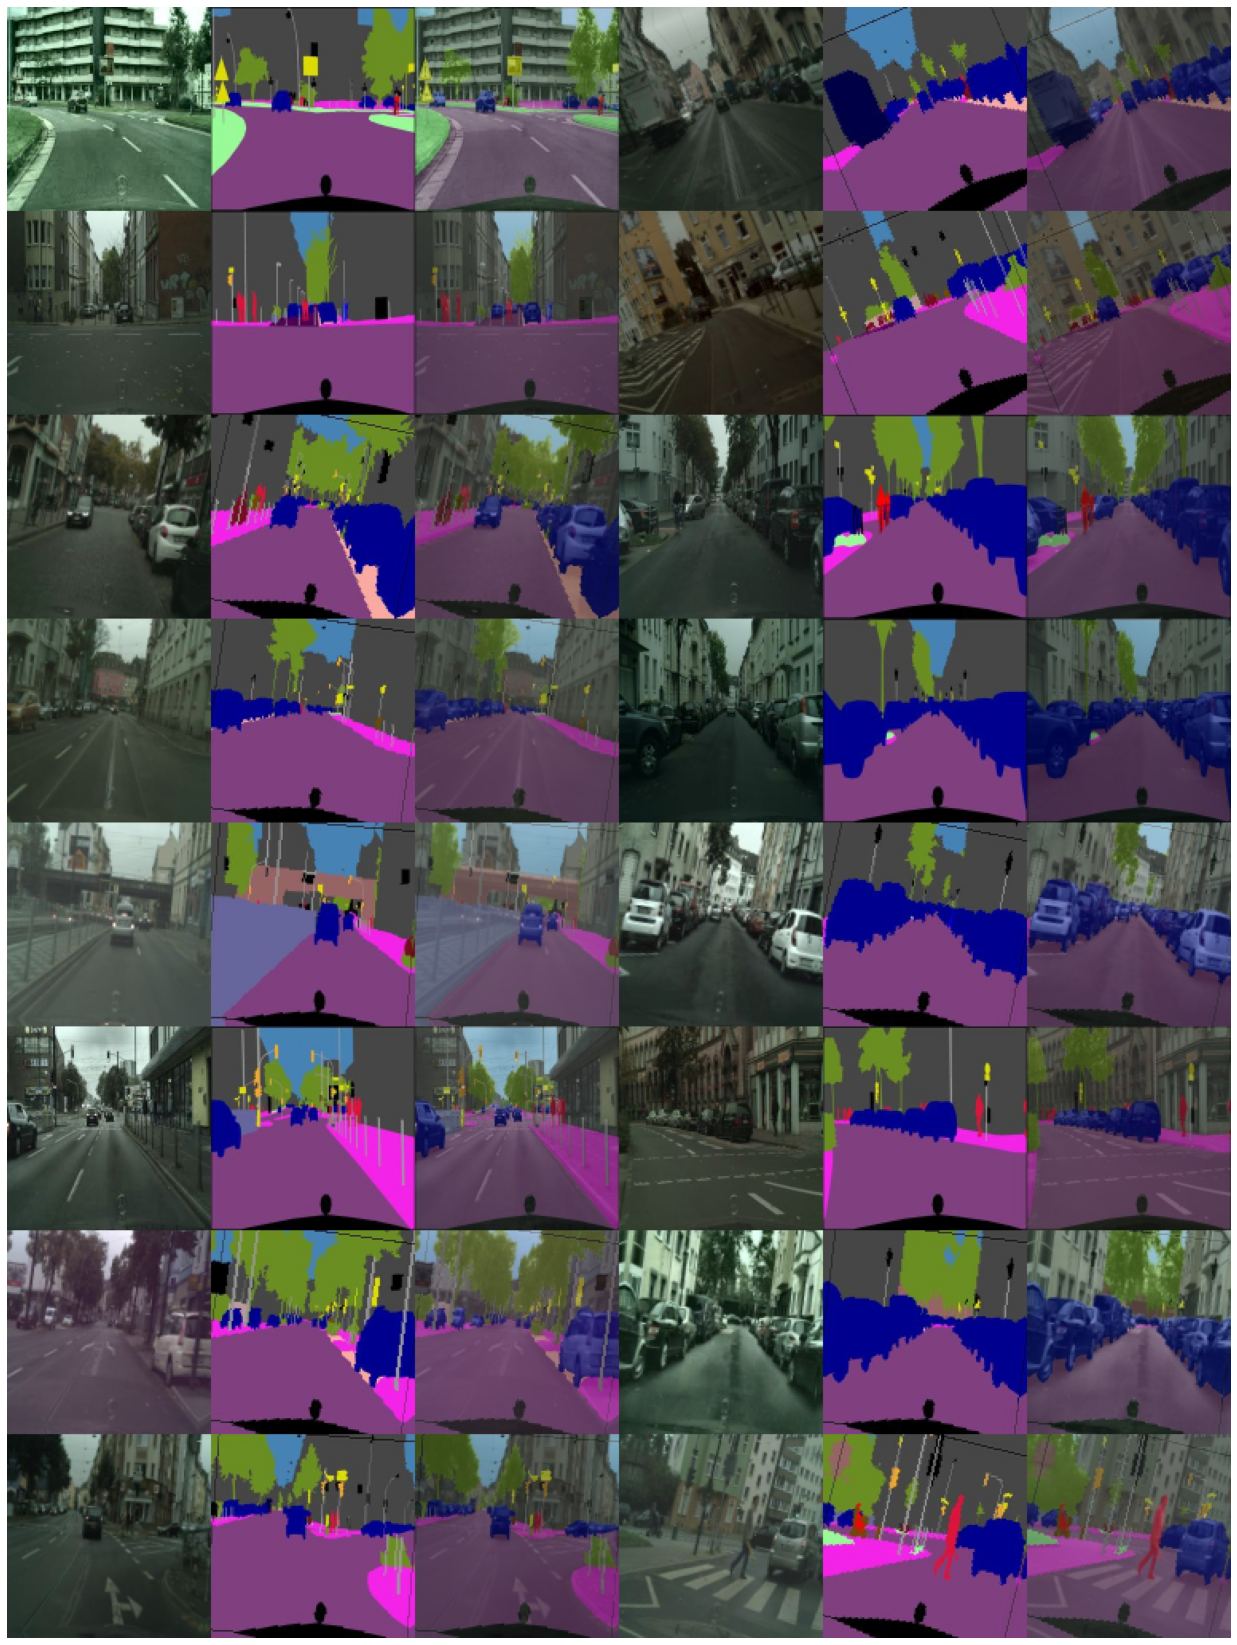

In [4]:
#function to perform data visualization 
def show_examples(num_cols):
    stacks = []
    #create a Generator class object with the given parameters 
    dataloader = Generator(images_dir = train_images_dir, batch_size = 8, is_augmentation = True, rescale = 255.0)
    #for loop iterating over num_cols 
    for iteration in range(num_cols):
        images, masks = next(dataloader)
        images, masks = images.numpy(), masks.numpy()
        images, masks = np.concatenate(np.moveaxis(images, 1, -1)), np.concatenate(np.moveaxis(masks, 1, -1))
        embedded = (images + masks) / 2
        stack = np.hstack([images, masks, embedded])
        stacks.append(stack)
    result = np.hstack(stacks)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)

show_examples(2)

In [5]:
#class named DoubleConv interiting from nn.Module class 
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    #defining the constructor with the following structure as mid_channels = convolution followed by batch normalization followed by 
    #LeakyReLU followed by convolution followed by  batch normalization and then lastly the leakyReLU activation function 

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.1),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )

    #function to perform the forward pass 
    def forward(self, x):
        return self.double_conv(x)


#class named Down inheriting from nn.Module class 
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    #constructor with maxpool_conv = max pooling followed by the DoubleConv object as defined in the previous class 
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    #function to perform the forward pass  for this module 
    def forward(self, x):
        return self.maxpool_conv(x)

#class named Up inheriting from nn.Module class
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    #function to perform the forward pass  for this module 
    #more details can be found in the UNet paper 
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


#class named OutConv inheriting from nn.Module class
class OutConv(nn.Module):
    #constructor with conv = convolutional layer
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    #function to perform the forward pass  for this module 
    def forward(self, x):
        return self.conv(x)



#class named UNet inheriting from nn.Module class
#defines the layers in the UNet architecture and their order and forwards pass functions 
#more details on the architecture can be found in the paper 
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits  

In [6]:
#create the UNet class' object with the following parameters 
unet = UNet(n_channels=3, n_classes=3, bilinear=True)
#initialization of the weights by passing a zero-filled matrix
x = torch.zeros(8, 3, 128, 128, dtype=torch.float, requires_grad=False)
out = unet(x)

In [7]:
#Adam optimizer for training the model 
#lr is the learning rate and other parameters can be found in the documentation 
optimizer = torch.optim.Adam(params = unet.parameters(), 
                             lr=1e-4, 
                             betas=(0.9, 0.999), 
                             eps=1e-08, 
                             weight_decay=0, 
                             amsgrad=False)

criterion = torch.nn.BCEWithLogitsLoss()

#dice score calculation function 
def dice_coeff(pred, target):
    pred = (pred > 0).float()
    return 2. * (pred*target).sum() / (pred+target).sum()


#function to perform training 
def training(model, epochs, batch_size):
    
    #create a train data generation and test data generator with the given parameters 
    train_generator = Generator(images_dir = train_images_dir, batch_size = batch_size, is_augmentation = True, rescale = 255.0)
    test_generator = Generator(images_dir = val_images_dir, batch_size = batch_size, is_augmentation = False, rescale = 255.0)
    
    #use a cuda-enabled gpu or a cpu for training 
    device = torch.device('cpu')
    model.to(device)

    #start with the loss of infinity 
    valid_loss_min = np.Inf

    #iterate through the number of epochs 
    for epoch in range(1, epochs+1):

        train_loss = 0.0
        valid_loss = 0.0
        train_dice_coeff = 0.0
        test_dice_coeff = 0.0

        #model training
        model.train()
        for i in range(len(train_generator)):
            #take a batch of training images
            train_images, train_masks = next(train_generator)
            train_images, train_masks = train_images.to(device), train_masks.to(device)
            
            #set the gradient of the optimiser to zero 
            optimizer.zero_grad()
            
            #make the predictions 
            train_predictions = model(train_images)
            
            #compare predictions with the ground truth 
            train_loss = criterion(train_predictions, train_masks)
            
            #perform the backward pass 
            train_loss.backward()

            #calculate the dice score 
            train_dice_coeff += dice_coeff(pred = train_predictions, target = train_masks)
            
            #set the calculate gradient and step size 
            optimizer.step()
            
            #add the loss 
            train_loss += train_loss.item()*train_images.size(0)

            #empty the cuda's cache if using cuda 
            torch.cuda.empty_cache()
        
        
        #model testing same as testing but without the opimizer gradient calculation and backward pass 
        model.eval()
        for i in range(len(test_generator)):

            test_images, test_masks = next(test_generator)
            test_images, test_masks = test_images.to(device), test_masks.to(device)

            test_predictions = model(test_images)

            test_loss = criterion(test_predictions, test_masks)

            test_dice_coeff += dice_coeff(pred = test_predictions, target = test_masks)

            valid_loss += test_loss.item()*test_images.size(0)

            torch.cuda.empty_cache()
        
        #calculate average losses and dice coefficient scores 
        train_loss = train_loss/len(train_generator)
        train_dice_coeff = train_dice_coeff/len(train_generator)

        valid_loss = valid_loss/len(test_generator)
        test_dice_coeff = test_dice_coeff/len(test_generator)
            
        #print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Dice Coeffienct: {:.6f} \tValidation Loss: {:.6f} \tValidation Dice Coeffienct: {:.6f} '.format(
            epoch, train_loss, train_dice_coeff ,valid_loss, test_dice_coeff))
        
        #saving the model provided the validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss

torch.cuda.empty_cache()

#calling the training function on the model with the given parameters 
training(model = unet, epochs = 10, batch_size = 32)

Epoch: 1 	Training Loss: 0.221662 	Training Dice Coeffienct: 0.514658 	Validation Loss: 19.319162 	Validation Dice Coeffienct: 0.511483 
Validation loss decreased (inf --> 19.319162).  Saving model ...
Epoch: 2 	Training Loss: 0.219041 	Training Dice Coeffienct: 0.503680 	Validation Loss: 18.405324 	Validation Dice Coeffienct: 0.501068 
Validation loss decreased (19.319162 --> 18.405324).  Saving model ...
Epoch: 3 	Training Loss: 0.212217 	Training Dice Coeffienct: 0.499650 	Validation Loss: 18.171799 	Validation Dice Coeffienct: 0.490180 
Validation loss decreased (18.405324 --> 18.171799).  Saving model ...
Epoch: 4 	Training Loss: 0.216161 	Training Dice Coeffienct: 0.493950 	Validation Loss: 18.093293 	Validation Dice Coeffienct: 0.501850 
Validation loss decreased (18.171799 --> 18.093293).  Saving model ...
Epoch: 5 	Training Loss: 0.210693 	Training Dice Coeffienct: 0.489604 	Validation Loss: 18.039402 	Validation Dice Coeffienct: 0.490584 
Validation loss decreased (18.093293 

In [9]:
#creating a UNet object with the given parameters
model = UNet(n_channels=3, n_classes=3, bilinear=True)
#loading the model weights from the model.pt weights file into the UNet object
model.load_state_dict(torch.load("model.pt"))
#observing the object
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

tensor(0.4549)
tensor(0.4366)


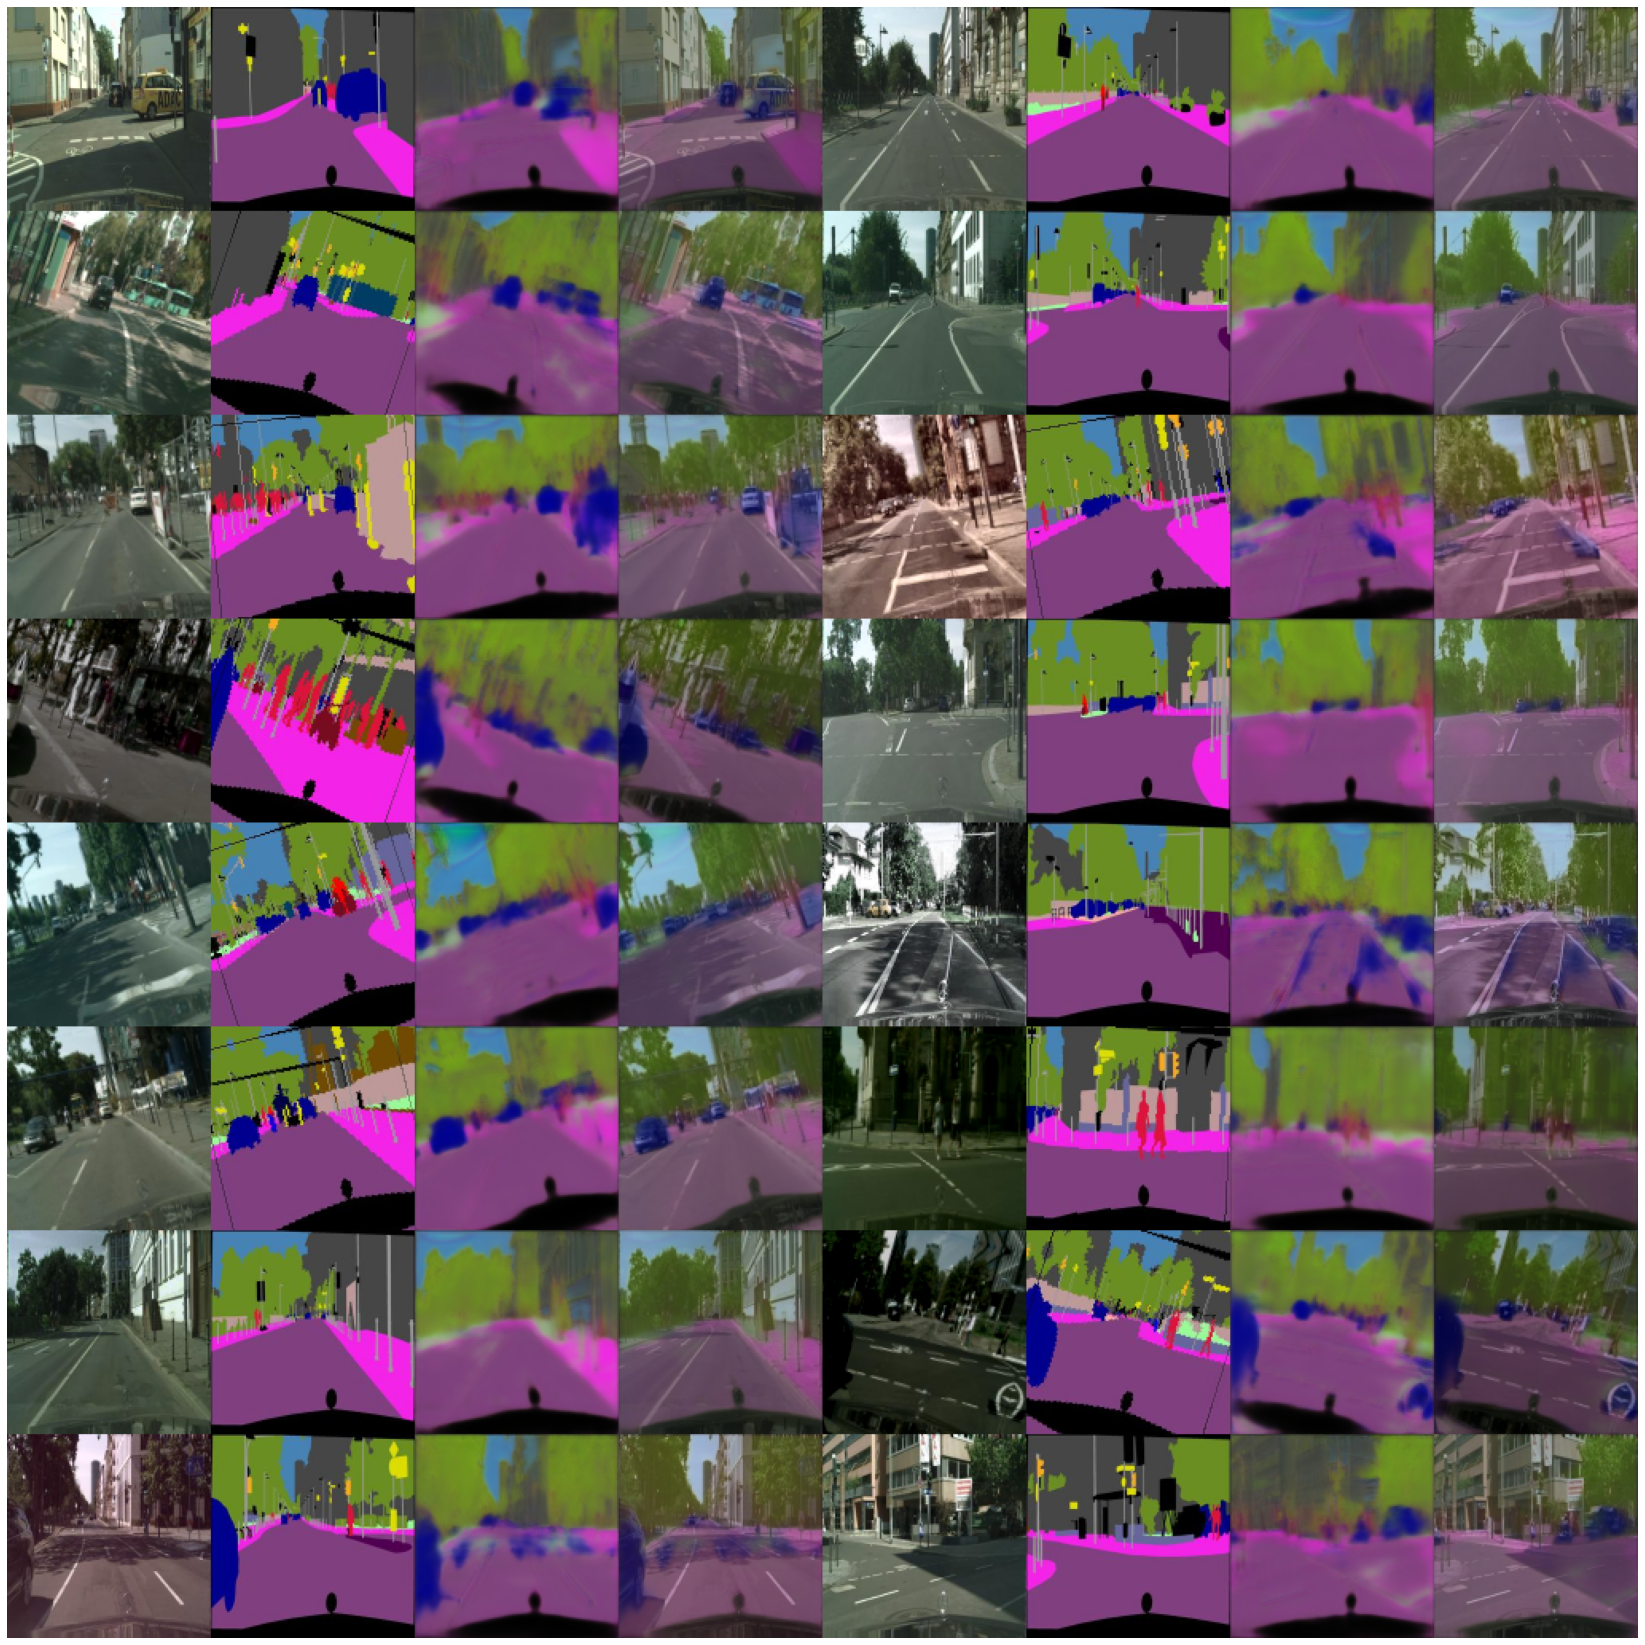

In [11]:
#function to display some input images from the testing dataset with the corresponding predictions from the trained model and 
#the ground truth images 
def show_final_results(num_cols):
    generator = Generator(images_dir = val_images_dir, 
                           batch_size = 8, 
                           is_augmentation = True, 
                           rescale = 255.0)
    result = []
    for iteration in range(num_cols):
        images, masks = next(generator)
        prediction = model(images)
        dc = dice_coeff(pred = prediction, target = masks)
        print(dc)
        prediction = torch.sigmoid(prediction)
        prediction = prediction.cpu().detach().numpy()
        prediction = np.moveaxis(prediction, 1, -1)
        masks = np.moveaxis(masks.numpy(), 1, -1)
        images = np.moveaxis(images.numpy(), 1, -1)
        prediction = np.concatenate(prediction)
        images = np.concatenate(images)
        masks = np.concatenate(masks)
        merged = np.add(images, prediction) / 2
        outputs = np.hstack([images, masks, prediction, merged])
        result.append(outputs)
        
    result = np.hstack(result)
    plt.figure(figsize = (30, 30))
    plt.axis('off')
    plt.imshow(result)
    
show_final_results(num_cols = 2)